In [190]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import xgboost as xgb
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# EDA

In [191]:
org_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
sample = pd.read_csv("data/sample_submission.csv")
features_df = pd.read_csv("cleaned_features.csv")

### Check Outliers

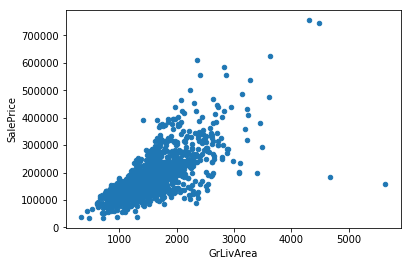

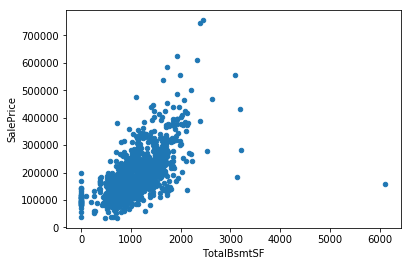

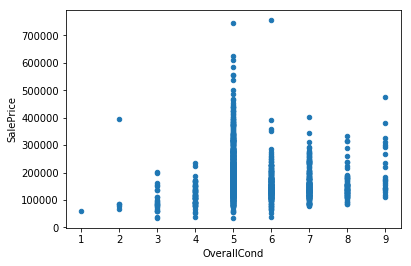

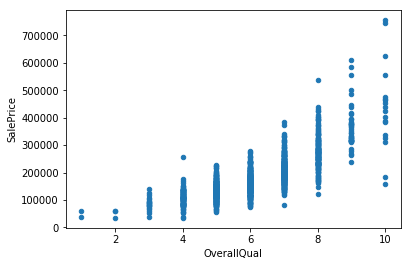

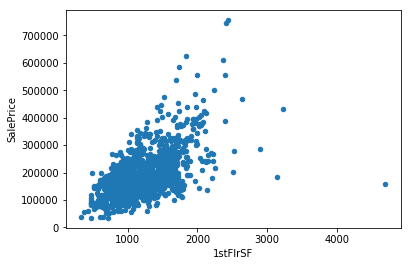

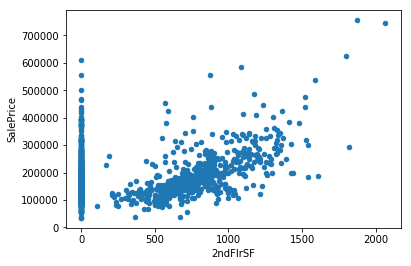

In [192]:
for col in ["GrLivArea", "TotalBsmtSF", "OverallCond", "OverallQual", "1stFlrSF", "2ndFlrSF"]:
    org_df.plot.scatter(x = col, y = "SalePrice")

### Remove Outliers

In [193]:
org_df = org_df.loc[org_df["GrLivArea"] < 4500]
org_df = org_df.loc[org_df["TotalBsmtSF"] < 6000]
org_df = org_df.loc[org_df["1stFlrSF"] < 4000]

In [194]:
org_df.shape

(1458, 81)

### Check Target Distribution

In [195]:
target = org_df["SalePrice"]
log_target = np.log(target)

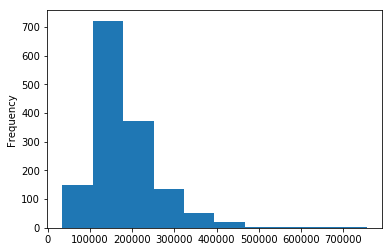

In [196]:
target.plot.hist()

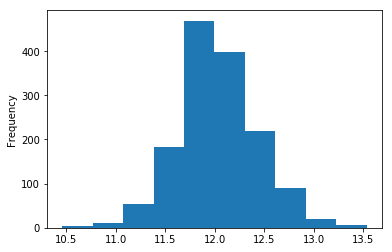

In [197]:
log_target.plot.hist()

In [198]:
print(org_df.shape)
print(test_df.shape)

(1458, 81)
(1459, 80)


# Feature Engineering

In [347]:
features_df = pd.concat([org_df, test_df], axis = 0).drop(["Id","SalePrice", "Utilities"], axis = 1)
features_df.shape

(2917, 78)

In [348]:
def get_nadf (df):
    cols_df = pd.DataFrame(df.isna().sum()[df.isna().sum() != 0])
    cols_df.columns = ["NAs"]
    cols_df["NA_Percentail"] = (cols_df["NAs"]/df.shape[0])*100
    return cols_df
get_nadf(features_df)

,NAs,NA_Percentail
Alley,2719,93.212204
BsmtCond,82,2.811107
BsmtExposure,82,2.811107
BsmtFinSF1,1,0.034282
BsmtFinSF2,1,0.034282
BsmtFinType1,79,2.708262
BsmtFinType2,80,2.742544
BsmtFullBath,2,0.068564
BsmtHalfBath,2,0.068564
BsmtQual,81,2.776826


In [349]:
# Fill NA with None and 0
for col in ["BsmtCond", "BsmtQual", "BsmtFinType1", "BsmtExposure", "BsmtFinType2", "GarageType", "GarageFinish",
           "GarageQual", "GarageCond", "Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature", "MasVnrType"]:
    features_df[col] = features_df[col].fillna("None")
    
for col in ["MasVnrArea", "GarageYrBlt", "TotalBsmtSF", "BsmtFinSF1", "BsmtFinSF2", "BsmtFullBath", "BsmtHalfBath",
           "BsmtUnfSF", "GarageArea", "GarageCars"]:
    features_df[col] = features_df[col].fillna(0)

for col in ["Electrical", "MSZoning", "Functional", "SaleType", "KitchenQual", "Exterior1st", "Exterior2nd"]:
    features_df[col] = features_df[col].fillna(features_df[col].mode()[0])

In [350]:
# Fill NA with Median
features_df["LotFrontage"] = features_df["LotFrontage"].fillna(np.median(features_df.loc[features_df["LotFrontage"].notnull(), "LotFrontage"]))

In [351]:
# Change to str because of not ordinal
features_df[["MSSubClass", "OverallQual", "OverallCond"]] = features_df[["MSSubClass", "OverallQual", "OverallCond"]].astype("object")

In [352]:
# Generate 8 new features
features_df["TotalSF"] = features_df["GrLivArea"] + features_df["TotalBsmtSF"]
features_df["YrBtwRemod"] = features_df["YrSold"] - features_df["YearRemodAdd"]
features_df["HouseAge"] = features_df["YrSold"] - features_df["YearBuilt"]

In [353]:
num_features = list(features_df.dtypes[features_df.dtypes!='object'].index)

Text(0.5, 0.98, '')

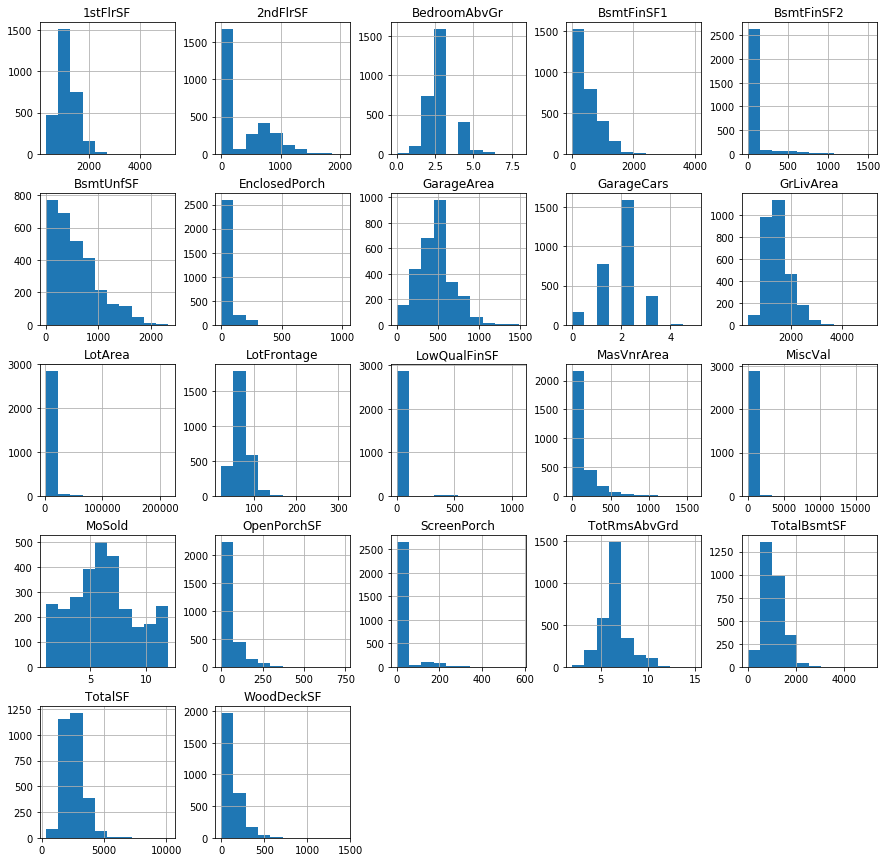

In [354]:
rm_lst = ['3SsnPorch', 'BsmtFullBath','BsmtHalfBath','Fireplaces','FullBath','GarageYrBlt','HalfBath','KitchenAbvGr',
         'PoolArea','HouseAge','YearBuilt','YearRemodAdd','YrBtwRemod','YrSold']
for e in rm_lst:
    num_features.remove(e)
features_df[num_features].hist(figsize=(15,15))
plt.suptitle("")

In [355]:
num_features

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'EnclosedPorch',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'MoSold',
 'OpenPorchSF',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'TotalSF']

In [356]:
x_forlog = ['1stFlrSF','GrLivArea','LotFrontage','TotalSF']
for col in x_forlog:
    features_df[col] = np.log1p(features_df[col])

Text(0.5, 0.98, '')

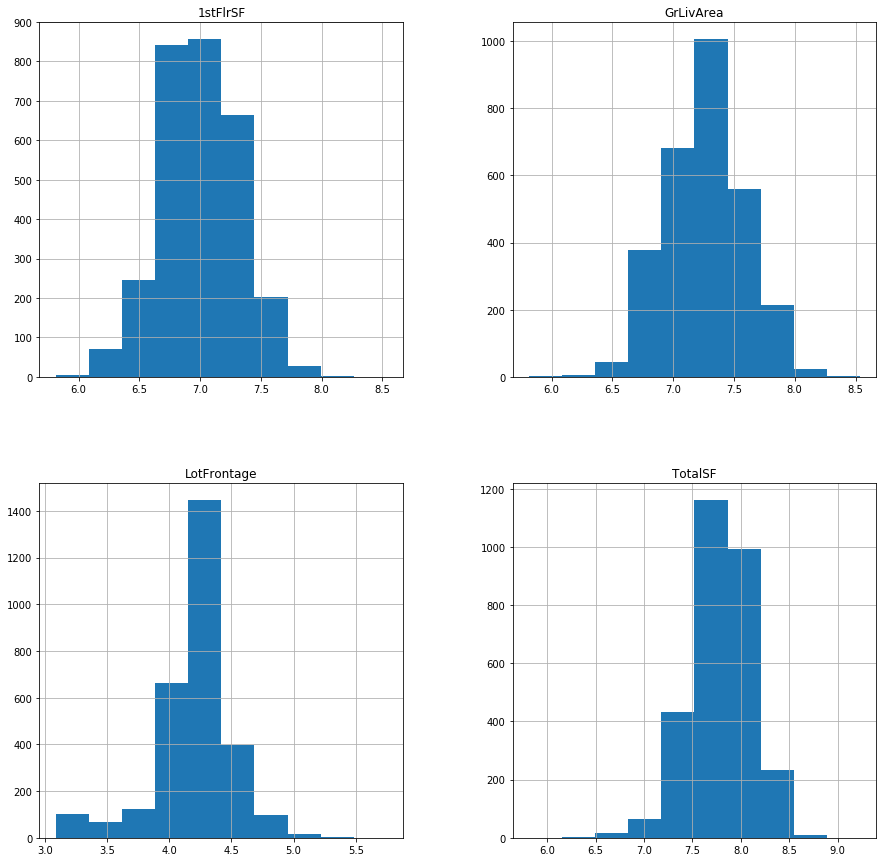

In [357]:
features_df[x_forlog].hist(figsize=(15,15))
plt.suptitle("")

# Modeling

In [358]:
dummied_features = pd.get_dummies(features_df, drop_first = True)
dummied_features.shape

(2917, 289)

In [359]:
train = dummied_features[:1458]
test = dummied_features[1458:]

## Lasso

In [362]:
lasso = Lasso()
alphas = np.linspace(0, 0.01, 100)
grid_param = [{"alpha": alphas}]
lasso.set_params(normalize = True)
n_folds = 5

clf = GridSearchCV(lasso, grid_param, cv = n_folds, n_jobs = -1)
clf.fit(train, log_target)
print(clf.best_score_)
print(clf.best_params_)

0.9148203396544515
{'alpha': 0.00010101010101010101}


In [250]:
# Using Lasso to check new feature importance
lasso = clf.best_estimator_
lasso.set_params(normalize = False)
lasso.fit(train, log_target)
coefs_df = pd.concat([pd.DataFrame(train.columns), pd.DataFrame(lasso.coef_)], axis = 1)
coefs_df.columns = ["Col", "Coef"]
coefs_df.sort_values(by="Coef", ascending = False)
coefs_df.loc[coefs_df["Col"] == "TotalSF"]

,Col,Coef
33,TotalSF,-0.000047


In [364]:
lasso_pre = clf.predict(test)

In [365]:
sample["SalePrice"] = np.exp(lasso_pre)
sample.to_csv("lasso0523.csv", index = False)

In [363]:
# RMSE
(np.mean((clf.predict(train) - log_target)**2))**.5

0.10205332588476321

### Residual plot to check assumptions

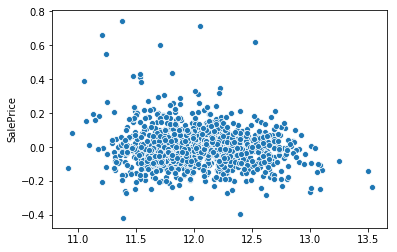

In [366]:
sns.scatterplot(x = pre_log_y, y = clf.predict(train)-log_target)

## Ridge

In [369]:
ridge = Ridge()
alphas = np.linspace(0.2, 0.3, 100)
grid_param = [{"alpha": alphas}]
ridge.set_params(normalize = True)
n_folds = 5

clf = GridSearchCV(ridge, grid_param, cv = n_folds)
clf.fit(train, log_target)
print(clf.best_score_)
print(clf.best_params_)

0.9086558476480437
{'alpha': 0.25555555555555554}


In [370]:
ridge_pre = clf.predict(test)
sample["SalePrice"] = np.exp(ridge_pre)
sample.to_csv("ridge0523.csv", index = False)

In [371]:
# RMSE
(np.mean((clf.predict(train) - log_target)**2))**.5

0.09736891405466257

## ElasticNet

In [123]:
ela = ElasticNet(normalize = True)
alphas = np.linspace(0, 0.001, 10)
l1r = [0.5]
grid_param = [{"alpha": alphas, "l1_ratio": l1r}]
n_folds = 5
clf = GridSearchCV(ela, grid_param, cv = n_folds, n_jobs = -1)
clf.fit(train, log_target)
print(clf.best_score_)
print(clf.best_params_)

0.9108177087609488
{'alpha': 0.00011111111111111112, 'l1_ratio': 0.5}


In [124]:
ela_pre = clf.predict(test)
sample["SalePrice"] = np.exp(ela_pre)
sample.to_csv("ela0522.csv", index = False)

In [125]:
# RMSE
(np.mean((clf.predict(train) - log_target)**2))**.5

0.09984517808658981

# Tree Models

In [127]:
le = preprocessing.LabelEncoder()
cat_cols = features_df.dtypes[(features_df.dtypes != "int64") & (features_df.dtypes != "float64")].index
tr_features = features_df.copy()

In [128]:
for col in cat_cols:
    tr_features[col] = le.fit_transform(tr_features[col])

In [129]:
tr_train = tr_features[:1458]
tr_test = tr_features[1458:]

## Gradient Boosting

In [162]:
gbm = GradientBoostingRegressor(max_features = "sqrt", learning_rate = 0.01)
depth = [3,4,5]
n_est = [1100,1200]
grid_param = [{"max_depth": depth, "n_estimators": n_est}]
n_folds = 5
clf = GridSearchCV(gbm, grid_param, cv = n_folds, n_jobs = -1)

In [163]:
clf.fit(tr_train, target)
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 3, 'n_estimators': 1200}
0.9183614578727713


In [164]:
sample["SalePrice"] = clf.predict(tr_test)
sample.to_csv("gbm0522.csv", index = False)

## Extreme Boosting

In [188]:
egb = xgb.XGBRegressor(silent = 1, eta = 0.01)
depth = [2,3,4]
n_est = [600]
csby = [0.2,0.3]
lb = [0.0000001]
grid_param = [{"max_depth": depth, "n_estimators": n_est, "colsample_bytree": csby, "lambda": lb}]
n_folds = 5
clf = GridSearchCV(egb, grid_param, cv = n_folds, n_jobs = -1)

In [189]:
clf.fit(tr_train,target)
print(clf.best_params_)
print(clf.best_score_)

{'colsample_bytree': 0.3, 'lambda': 1e-07, 'max_depth': 2, 'n_estimators': 600}
0.9174549912355114


In [187]:
sample["SalePrice"] = clf.predict(tr_test)
sample.to_csv("xgb0522.csv", index = False)

# Stacking

In [373]:
gbm0522 = pd.read_csv('gbm0522.csv')
ela0522 = pd.read_csv('ela0522.csv')

In [374]:
sample["SalePrice"] = (gbm0522["SalePrice"]+ela0522["SalePrice"])/2
sample.to_csv("gbm_ela0523.csv", index = False)

In [15]:
x_lintr, x_lintst, y_tr = strain, test, slog_target
x_treetr, x_treetst = str_train, tr_test

In [16]:
kf = KFold(n_splits=5, random_state = 0, shuffle = False)

In [25]:
lasso_train = []
lasso_test = []
for tr, ts in kf.split(x_lintr):
    train_idx = list(x_lintr.index[tr])
    test_idx = list(x_lintr.index[ts])
    lasso = Lasso(alpha = 0.000105, normalize = False)
    lasso.fit(x_lintr.loc[train_idx],y_tr.loc[train_idx])
    lasso_train.extend(lasso.predict(x_lintr.loc[test_idx]))
    lasso_test.append(lasso.predict(x_lintst))
lasso_test = [e/5 for e in sum(lasso_test)]

In [26]:
ridge_train = []
ridge_test = []
for tr, ts in kf.split(x_lintr):
    train_idx = list(x_lintr.index[tr])
    test_idx = list(x_lintr.index[ts])
    ridge = Ridge(alpha = 0.000105, normalize = False)
    ridge.fit(x_lintr.loc[train_idx],y_tr.loc[train_idx])
    ridge_train.extend(ridge.predict(x_lintr.loc[test_idx]))
    ridge_test.append(ridge.predict(x_lintst))
ridge_test = [e/5 for e in sum(ridge_test)]

In [27]:
ela_train = []
ela_test = []
for tr, ts in kf.split(x_lintr):
    train_idx = list(x_lintr.index[tr])
    test_idx = list(x_lintr.index[ts])
    ela = ElasticNet(alpha = 0.000105, l1_ratio = 0.5333, normalize=False)
    ela.fit(x_lintr.loc[train_idx],y_tr.loc[train_idx])
    ela_train.extend(ela.predict(x_lintr.loc[test_idx]))
    ela_test.append(ela.predict(x_lintst))
ela_test = [e/5 for e in sum(ela_test)]

In [28]:
gbm_train = []
gbm_test = []
for tr, ts in kf.split(x_treetr):
    train_idx = list(x_treetr.index[tr])
    test_idx = list(x_treetr.index[ts])
    gbm = GradientBoostingRegressor(max_features = "sqrt", learning_rate = 0.03, max_depth = 2, n_estimators = 3000, loss = "huber")
    gbm.fit(x_treetr.loc[train_idx],y_tr.loc[train_idx])
    gbm_train.extend(gbm.predict(x_treetr.loc[test_idx]))
    gbm_test.append(gbm.predict(x_treetst))
gbm_test = [e/5 for e in sum(gbm_test)]

In [30]:
stacked_train = pd.DataFrame({"lasso":lasso_train,"ridge": ridge_train,"ela": ela_train,"gbm": gbm_train})
stacked_test = pd.DataFrame({"lasso":lasso_test,"ridge": ridge_test,"ela": ela_test,"gbm": gbm_test})
stacked_train.to_csv("stacked_train.csv", index = False)
stacked_test.to_csv("stacked_test.csv", index = False)

In [27]:
stacked_train["lasso"] = np.log(lasso3["SalePrice"])

In [29]:
stacked_train.to_csv("stacked_train.csv", index = False)
stacked_test.to_csv("stacked_test.csv", index = False)

In [17]:
xgb_train = []
xgb_test = []
for tr, ts in kf.split(x_treetr):
    train_idx = list(x_treetr.index[tr])
    test_idx = list(x_treetr.index[ts])
    egb = xgb.XGBRegressor(loss = "huber", eta = 0.01, max_depth = 3, n_estimators = 600, colsample_bytree = 0.5)
    egb.fit(x_treetr.loc[train_idx],y_tr.loc[train_idx])
    xgb_train.extend(egb.predict(x_treetr.loc[test_idx]))
    xgb_test.append(egb.predict(x_treetst))
xgb_test = [e/5 for e in sum(xgb_test)]

In [3]:
stacked_train = pd.read_csv("stacked_train.csv")
stacked_test = pd.read_csv("stacked_test.csv")

In [19]:
stacked_train["xgb"] = xgb_train
stacked_test["xgb"] = xgb_test

In [33]:
lasso = Lasso(alpha = 0, normalize = False)
lasso.fit(stacked_train, slog_target)
stacked_pre = lasso.predict(stacked_test)

In [35]:
sample["SalePrice"] = np.exp(stacked_pre)
sample.to_csv("StackedRegressor.csv", index = False)

In [36]:
lasso = Lasso(alpha = 0.000105, normalize = False)
ridge = Ridge(alpha = 0.000105, normalize = False)
ela = ElasticNet(alpha = 0.000105, l1_ratio = 0.5333, normalize=False)

stregr = StackingRegressor(regressors=[lasso,ridge,ela], meta_regressor=lasso)

In [37]:
stregr.fit(train,log_target)
str_pre = stregr.predict(test)

In [39]:
sample["SalePrice"] = np.exp(str_pre)
sample.to_csv("stackedlinear.csv", index = False)

In [192]:
sample["SalePrice"] = gbmfinal["SalePrice"]*0.25 + lasso3*0.5 + xgbfinal["SalePrice"]*0.25
sample.to_csv("la6.csv", index = False)